In [ ]:
# # Cambridge Weather Data Analysis
# This notebook downloads, caches, and visualizes mid-day temperature data for Cambridge, UK.

# ## Imports and Setup
import os
from datetime import datetime, date, timedelta
import pandas as pd
import numpy as np
import requests
import yaml
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from typing import Iterator, List, Dict, Any, Optional

# ## Parameters
SEARCH_TIMESTAMPS_FILE = "search_timestamps.yaml"
RELOAD_INTERVAL_DAYS = 1
num_years = 24
last_year = datetime.today().year
first_year = last_year - num_years + 1
start_date = date(first_year, 1, 1)
end_date = date.today()
polar_plots_num_cols = 6
polar_plots_num_rows = num_years//polar_plots_num_cols + (num_years % polar_plots_num_cols > 0)
data_dir = 'data'  # Directory for per-year YAML files

# ## Helper Functions

# Generate a range of dates from start_date to end_date (exclusive)
def daterange(start_date: date, end_date: date) -> Iterator[date]:
    """Yield each date from start_date (inclusive) to end_date (exclusive)."""
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

# Parse raw weather data string into a DataFrame for a specific date
def parse_data(data: str, dt: date) -> pd.DataFrame:
    """
    Parse the raw weather data string into a DataFrame for a specific date.
    Args:
        data: Raw weather data as a string.
        dt: The date for which the data applies.
    Returns:
        DataFrame with columns for each meteorological variable, time, year, and date.
    """
    df = pd.DataFrame()
    if not data or (data == "No data found for that date"):
        return df
    try:
        all_rows = data.split('\n')
        all_rows = [r.strip() for r in all_rows if r.strip()]
        data_rows = [r for r in all_rows if not r.startswith('#')]
        data_rows = [r.split('\t') for r in data_rows]
        headers = [r.split('\t') for r in all_rows if r.startswith('#')][-2]
        headers = [h.strip('#').strip() for h in headers]
        units = [r.split('\t') for r in all_rows if r.startswith('#')][-1]
        units = [u.strip('#').strip() for u in units]
        time_data = [datetime.strptime(x[0], '%H:%M').replace(year=dt.year, month=dt.month, day=dt.day) for x in data_rows]
        y_data = {
            '{} ({})'.format(header, units[x+1]): [r[x+1] for r in data_rows]
            for x, header in enumerate(headers[1:])
        }
        y_data.update({'time': [d.strftime('%H:%M') for d in time_data]})
        y_data.update({'year': [dt.year for d in time_data]})
        df = pd.DataFrame(y_data)
        df['date'] = dt.strftime('%Y:%m:%d')
    except Exception as e:
        print(f"Error parsing data for date {dt}: {e}")
    return df

# Download Cambridge weather data for a single date
def get_cambridge_weather(single_date: date, timeout: int = 500) -> pd.DataFrame:
    """
    Download Cambridge weather data for a single date.
    Args:
        single_date: The date to fetch data for.
        timeout: Request timeout in seconds (default 500).
    Returns:
        DataFrame with parsed weather data for the date.
    """
    url = single_date.strftime('https://www.cl.cam.ac.uk/research/dtg/weather/daily-text.cgi?%Y-%m-%d')
    response = requests.get(url, timeout=timeout)
    data = response.text
    return parse_data(data, single_date)

# Save a DataFrame to a YAML file as a list of records
def save_df_to_yaml(df: pd.DataFrame, filename: str) -> None:
    """Save a DataFrame to a YAML file as a list of records."""
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    records = df.to_dict(orient='records')
    with open(filename, 'w') as f:
        yaml.safe_dump(records, f, default_flow_style=False)

# Load a DataFrame from a YAML file if it exists, else return None
def load_df_from_yaml(filename: str) -> Optional[pd.DataFrame]:
    """Load a DataFrame from a YAML file if it exists, else return None."""
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            records = yaml.safe_load(f)
        return pd.DataFrame(records)
    return None

# Extract the row corresponding to 12:00 (noon) from a day's DataFrame and compute derived fields
def extract_noon_row(df_day: pd.DataFrame) -> pd.DataFrame:
    """
    Extract the row corresponding to 12:00 (noon) from a day's DataFrame and compute derived fields.
    Args:
        df_day: DataFrame for a single day's weather data.
    Returns:
        DataFrame with only the noon row, including day_of_year and angle columns if available.
    """
    if df_day.empty:
        return df_day
    df_noon_row = df_day[df_day['time'] == '12:00'].copy()
    if not df_noon_row.empty:
        df_noon_row['day_of_year'] = df_noon_row['date'].apply(lambda x: pd.Period(datetime.strptime(x, '%Y:%m:%d'), freq='D').dayofyear)
        df_noon_row['angle'] = df_noon_row['day_of_year'] / 365.25 * 2 * np.pi
        df_noon_row['Temp (deg C)'] = df_noon_row['Temp (deg C)'].astype(float)
    return df_noon_row

# Load the search timestamps from the YAML file in the data directory, or return an empty dict if not found
def load_search_timestamps() -> Dict[str, str]:
    """Load the search timestamps from the YAML file in the data directory, or return an empty dict if not found."""
    path = os.path.join(data_dir, SEARCH_TIMESTAMPS_FILE)
    if os.path.exists(path):
        with open(path, 'r') as f:
            return yaml.safe_load(f) or {}
    return {}

# Save the search timestamps dictionary to the YAML file in the data directory
def save_search_timestamps(timestamps: Dict[str, str]) -> None:
    """Save the search timestamps dictionary to the YAML file in the data directory."""
    os.makedirs(data_dir, exist_ok=True)
    path = os.path.join(data_dir, SEARCH_TIMESTAMPS_FILE)
    with open(path, 'w') as f:
        yaml.safe_dump(timestamps, f, default_flow_style=False)

# Determine if a year's data should be reloaded based on the last fetch timestamp and interval
def should_reload_year(year: int, timestamps: Dict[str, str], interval_days: int = RELOAD_INTERVAL_DAYS) -> bool:
    """Determine if a year's data should be reloaded based on the last fetch timestamp and interval."""
    last = timestamps.get(str(year))
    if not last:
        return True
    try:
        last_dt = datetime.fromisoformat(last)
    except Exception:
        return True
    return (datetime.now() - last_dt) > timedelta(days=interval_days)

# Update the fetch timestamp for a given year and save to file
def update_year_timestamp(year: int, timestamps: Dict[str, str]) -> None:
    """Update the fetch timestamp for a given year and save to file."""
    timestamps[str(year)] = datetime.now().isoformat()
    save_search_timestamps(timestamps)

# Fetch missing dates from the web, update per-year YAML files, and reload all years
def fetch_and_update_missing_dates(missing_dates: List[date], all_years: List[int]) -> pd.DataFrame:
    """
    Fetch missing dates from the web, update per-year YAML files, and reload all years.
    Args:
        missing_dates: List of date objects to fetch.
        all_years: List of years to reload after update.
    Returns:
        DataFrame with all noon temperature data after update.
    """
    print(f"Fetching {len(missing_dates)} missing days from web if enough time since last fetch...")
    failed_dates = []
    last_printed_year = None
    year_rows = {}
    timestamps = load_search_timestamps()
    years_with_missing_dates = sorted(set(d.year for d in missing_dates))
    for year in years_with_missing_dates:
        if year != last_printed_year:
            print(year, end=' ', flush=True)
            last_printed_year = year
        # Only reload from web if interval has passed
        if not should_reload_year(year, timestamps):
            continue
        else:
            year_rows[year] = []
            path = year_yaml_path(year)
            df_existing = load_df_from_yaml(path)
            missing_dates_for_year = [d for d in missing_dates if d.year == year]
            for single_date in missing_dates_for_year:
                try:
                    df_day = get_cambridge_weather(single_date)
                    df_noon_row = extract_noon_row(df_day)
                    if not df_noon_row.empty:
                        # Filter to only date, year, and Temp (deg C)
                        df_noon_row = df_noon_row[['date', 'year', 'Temp (deg C)']]
                        year_rows[year].append(df_noon_row)
                except Exception as e:
                    print(f"\nDate: {single_date.strftime('%Y-%m-%d')}; Exception: {e}")
                    failed_dates.append(single_date)
            # Save after done with this year
            df_new = pd.concat(year_rows[year], ignore_index=True)
            if df_existing is not None and not df_existing.empty:
                df_combined = pd.concat([df_existing, df_new], ignore_index=True).drop_duplicates(subset=['date'])
            else:
                df_combined = df_new
            df_combined = df_combined.sort_values('date').reset_index(drop=True)
            save_df_to_yaml(df_combined, path)
            # Update timestamp for this year
            update_year_timestamp(year, timestamps)
            # Clear the list for this year after saving
            year_rows[year] = []
    print()  # Newline after all years printed
    # Reload all years after update
    df_noon = load_all_years(all_years)
    if failed_dates:
        print(f"Failed to fetch data for {len(failed_dates)} dates. See log above.")
    return df_noon

# Return the YAML file path for a given year
def year_yaml_path(year: int) -> str:
    """Return the YAML file path for a given year."""
    return os.path.join(data_dir, f"{year}.yaml")

# Load noon temperature data for all years from YAML files, recompute derived fields if missing
def load_all_years(years: List[int]) -> pd.DataFrame:
    """
    Load noon temperature data for all years from YAML files, recompute derived fields if missing.
    Args:
        years: List of years to load.
    Returns:
        DataFrame with noon temperature data for all years.
    """
    dfs = []
    for year in years:
        path = year_yaml_path(year)
        df = load_df_from_yaml(path)
        if df is not None and not df.empty:
            # Recompute derived fields if missing
            if 'day_of_year' not in df.columns or 'angle' not in df.columns:
                df['day_of_year'] = df['date'].apply(lambda x: pd.Period(datetime.strptime(x, '%Y:%m:%d'), freq='D').dayofyear)
                df['angle'] = df['day_of_year'] / 365.25 * 2 * np.pi
            if 'Temp (deg C)' in df.columns:
                df['Temp (deg C)'] = df['Temp (deg C)'].astype(float)
            dfs.append(df)
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        return pd.DataFrame(columns=['date', 'year', 'Temp (deg C)', 'day_of_year', 'angle'])

# Main entry point: Load noon temperature data for the given date range, fetching missing data as needed
def get_noon_temperature_data(start_date: date, end_date: date) -> pd.DataFrame:
    """
    Main entry point: Load noon temperature data for the given date range, fetching missing data as needed.
    Args:
        start_date: Start date (inclusive).
        end_date: End date (exclusive).
    Returns:
        DataFrame with noon temperatures for all available days.
    """
    all_dates = list(daterange(start_date, end_date))
    all_years = sorted(set(d.year for d in all_dates))
    # Load all available data from YAML
    df_noon = load_all_years(all_years)
    # Find which dates are missing
    if not df_noon.empty:
        loaded_dates = set(df_noon['date'])
    else:
        loaded_dates = set()
    missing_dates = [d for d in all_dates if d.strftime('%Y:%m:%d') not in loaded_dates]
    print(f"Loaded {len(loaded_dates)} days from file; {len(missing_dates)} days to fetch from web.")
    if missing_dates:
        df_noon = fetch_and_update_missing_dates(missing_dates, all_years)
    return df_noon

# ## Polar Plot of Mid-Day Temperatures
# Calculate temperature bounds and normalization for color mapping

df_noon = get_noon_temperature_data(start_date, end_date)
Tmin = 5 * np.floor(df_noon['Temp (deg C)'].min() / 5)
Tmax = 5 * np.ceil(df_noon['Temp (deg C)'].max() / 5)
Tmin_F = Tmin * 9/5 + 32
Tmax_F = Tmax * 9/5 + 32
norm = Normalize(vmin=Tmin, vmax=Tmax)


Loaded 8583 days from file; 179 days to fetch from web.
Fetching 179 missing days from web if enough time since last fetch...
2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 


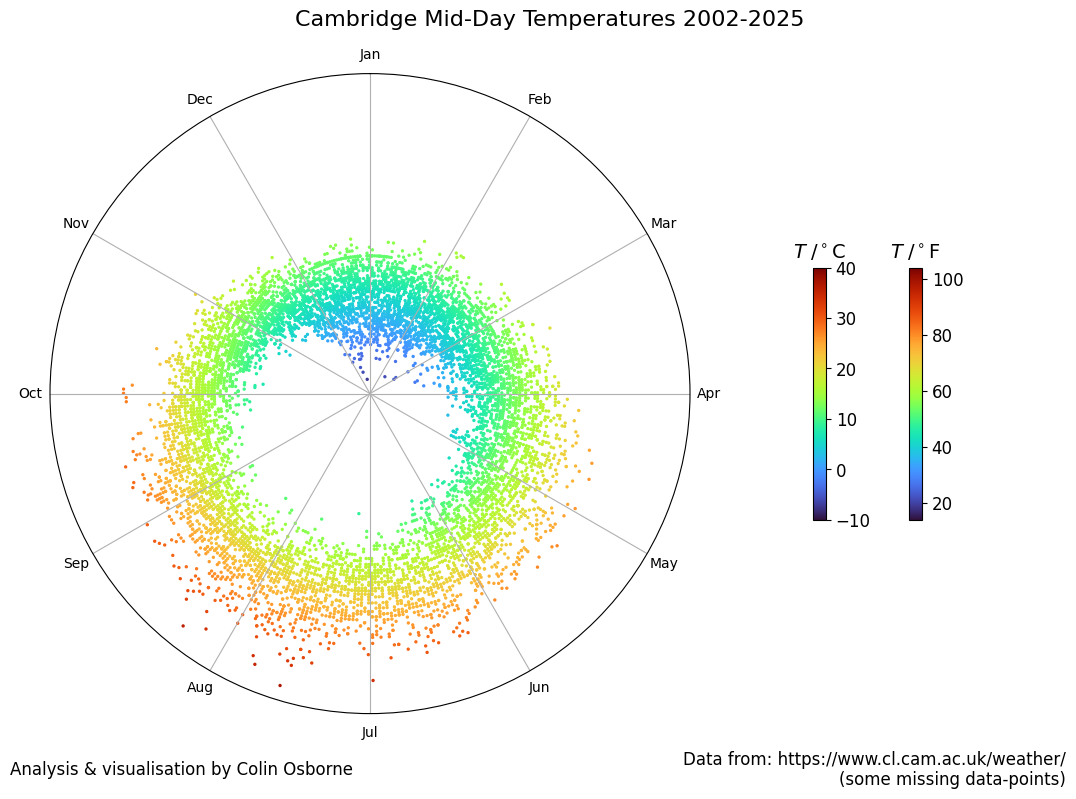

In [ ]:
def add_dual_colorbars(fig: plt.Figure, cmap, Tmin: float, Tmax: float, Tmin_F: float, Tmax_F: float, left_c: float = 0.66, left_f: float = 0.74, bottom: float = 0.10, width: float = 0.07, height: float = 0.8, fontsize: int = 14) -> None:
    """
    Add Celsius and Fahrenheit colorbars to a figure with improved sizing and font.
    Args:
        fig: Matplotlib Figure object.
        cmap: Colormap to use.
        Tmin, Tmax: Min and max temperature for Celsius colorbar.
        Tmin_F, Tmax_F: Min and max temperature for Fahrenheit colorbar.
        left_c, left_f, bottom, width, height: Position and size of colorbars.
        fontsize: Font size for colorbar labels.
    """
    # Celsius colorbar
    cbar_ax_c = fig.add_axes([left_c, bottom, width, height], frameon=False)
    cbar_ax_c.set_yticks([]), cbar_ax_c.set_xticks([])
    norm_c = Normalize(vmin=Tmin, vmax=Tmax)
    cbar_c = plt.colorbar(cm.ScalarMappable(norm=norm_c, cmap=cmap),
                         ax=cbar_ax_c, orientation='vertical')
    cbar_c.ax.set_title(r'$T\;/^\circ\mathrm{C}$', fontsize=fontsize)
    cbar_c.ax.tick_params(labelsize=fontsize-2)
    # Fahrenheit colorbar
    cbar_ax_f = fig.add_axes([left_f, bottom, width, height], frameon=False)
    cbar_ax_f.set_yticks([]), cbar_ax_f.set_xticks([])
    norm_f = Normalize(vmin=Tmin_F, vmax=Tmax_F)
    cbar_f = plt.colorbar(cm.ScalarMappable(norm=norm_f, cmap=cmap),
                         ax=cbar_ax_f, orientation='vertical')
    cbar_f.ax.set_title(r'$T\;/^\circ\mathrm{F}$', fontsize=fontsize)
    cbar_f.ax.tick_params(labelsize=fontsize-2)

def plot_polar(df: pd.DataFrame) -> None:
    """
    Plot a single polar plot of mid-day temperatures for all years in the DataFrame.
    Args:
        df: DataFrame with noon temperature data, including 'angle' and 'Temp (deg C)'.
    """
    fig = plt.figure(figsize=(12, 8))
    # Move polar plot further left
    ax = fig.add_axes([0.05, 0.1, 0.6, 0.8], polar=True)
    cmap = cm.turbo
    c = norm(df['Temp (deg C)'])
    ax.scatter(df['angle'], df['Temp (deg C)'], c=cmap(c), s=2)
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.set_xticks(np.arange(0, 2 * np.pi, np.pi / 6))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_yticks([])
    # Add dual colorbars closer to the polar plot
    add_dual_colorbars(fig, cmap, Tmin, Tmax, Tmin_F, Tmax_F, left_c=0.66, left_f=0.74, bottom=0.10, width=0.07, height=0.8, fontsize=14)
    first_year = df['year'].min()
    last_year = df['year'].max()
    plt.suptitle(f"Cambridge Mid-Day Temperatures {first_year}-{last_year}", fontsize=16, ha='center', x=0.5)
    plt.figtext(0.05, 0.03, 'Analysis & visualisation by Colin Osborne', verticalalignment='center', horizontalalignment='left', fontsize=12)
    plt.figtext(0.93, 0.03, 'Data from: https://www.cl.cam.ac.uk/weather/\n(some missing data-points)',
                verticalalignment='center', horizontalalignment='right', fontsize=12)
    plt.show()
    fig.savefig(f'CambridgeMidDayTemp_{first_year}_{last_year}.png')

plot_polar(df_noon)


num years: 24 ; num_cols: 6 ; num_rows: 4


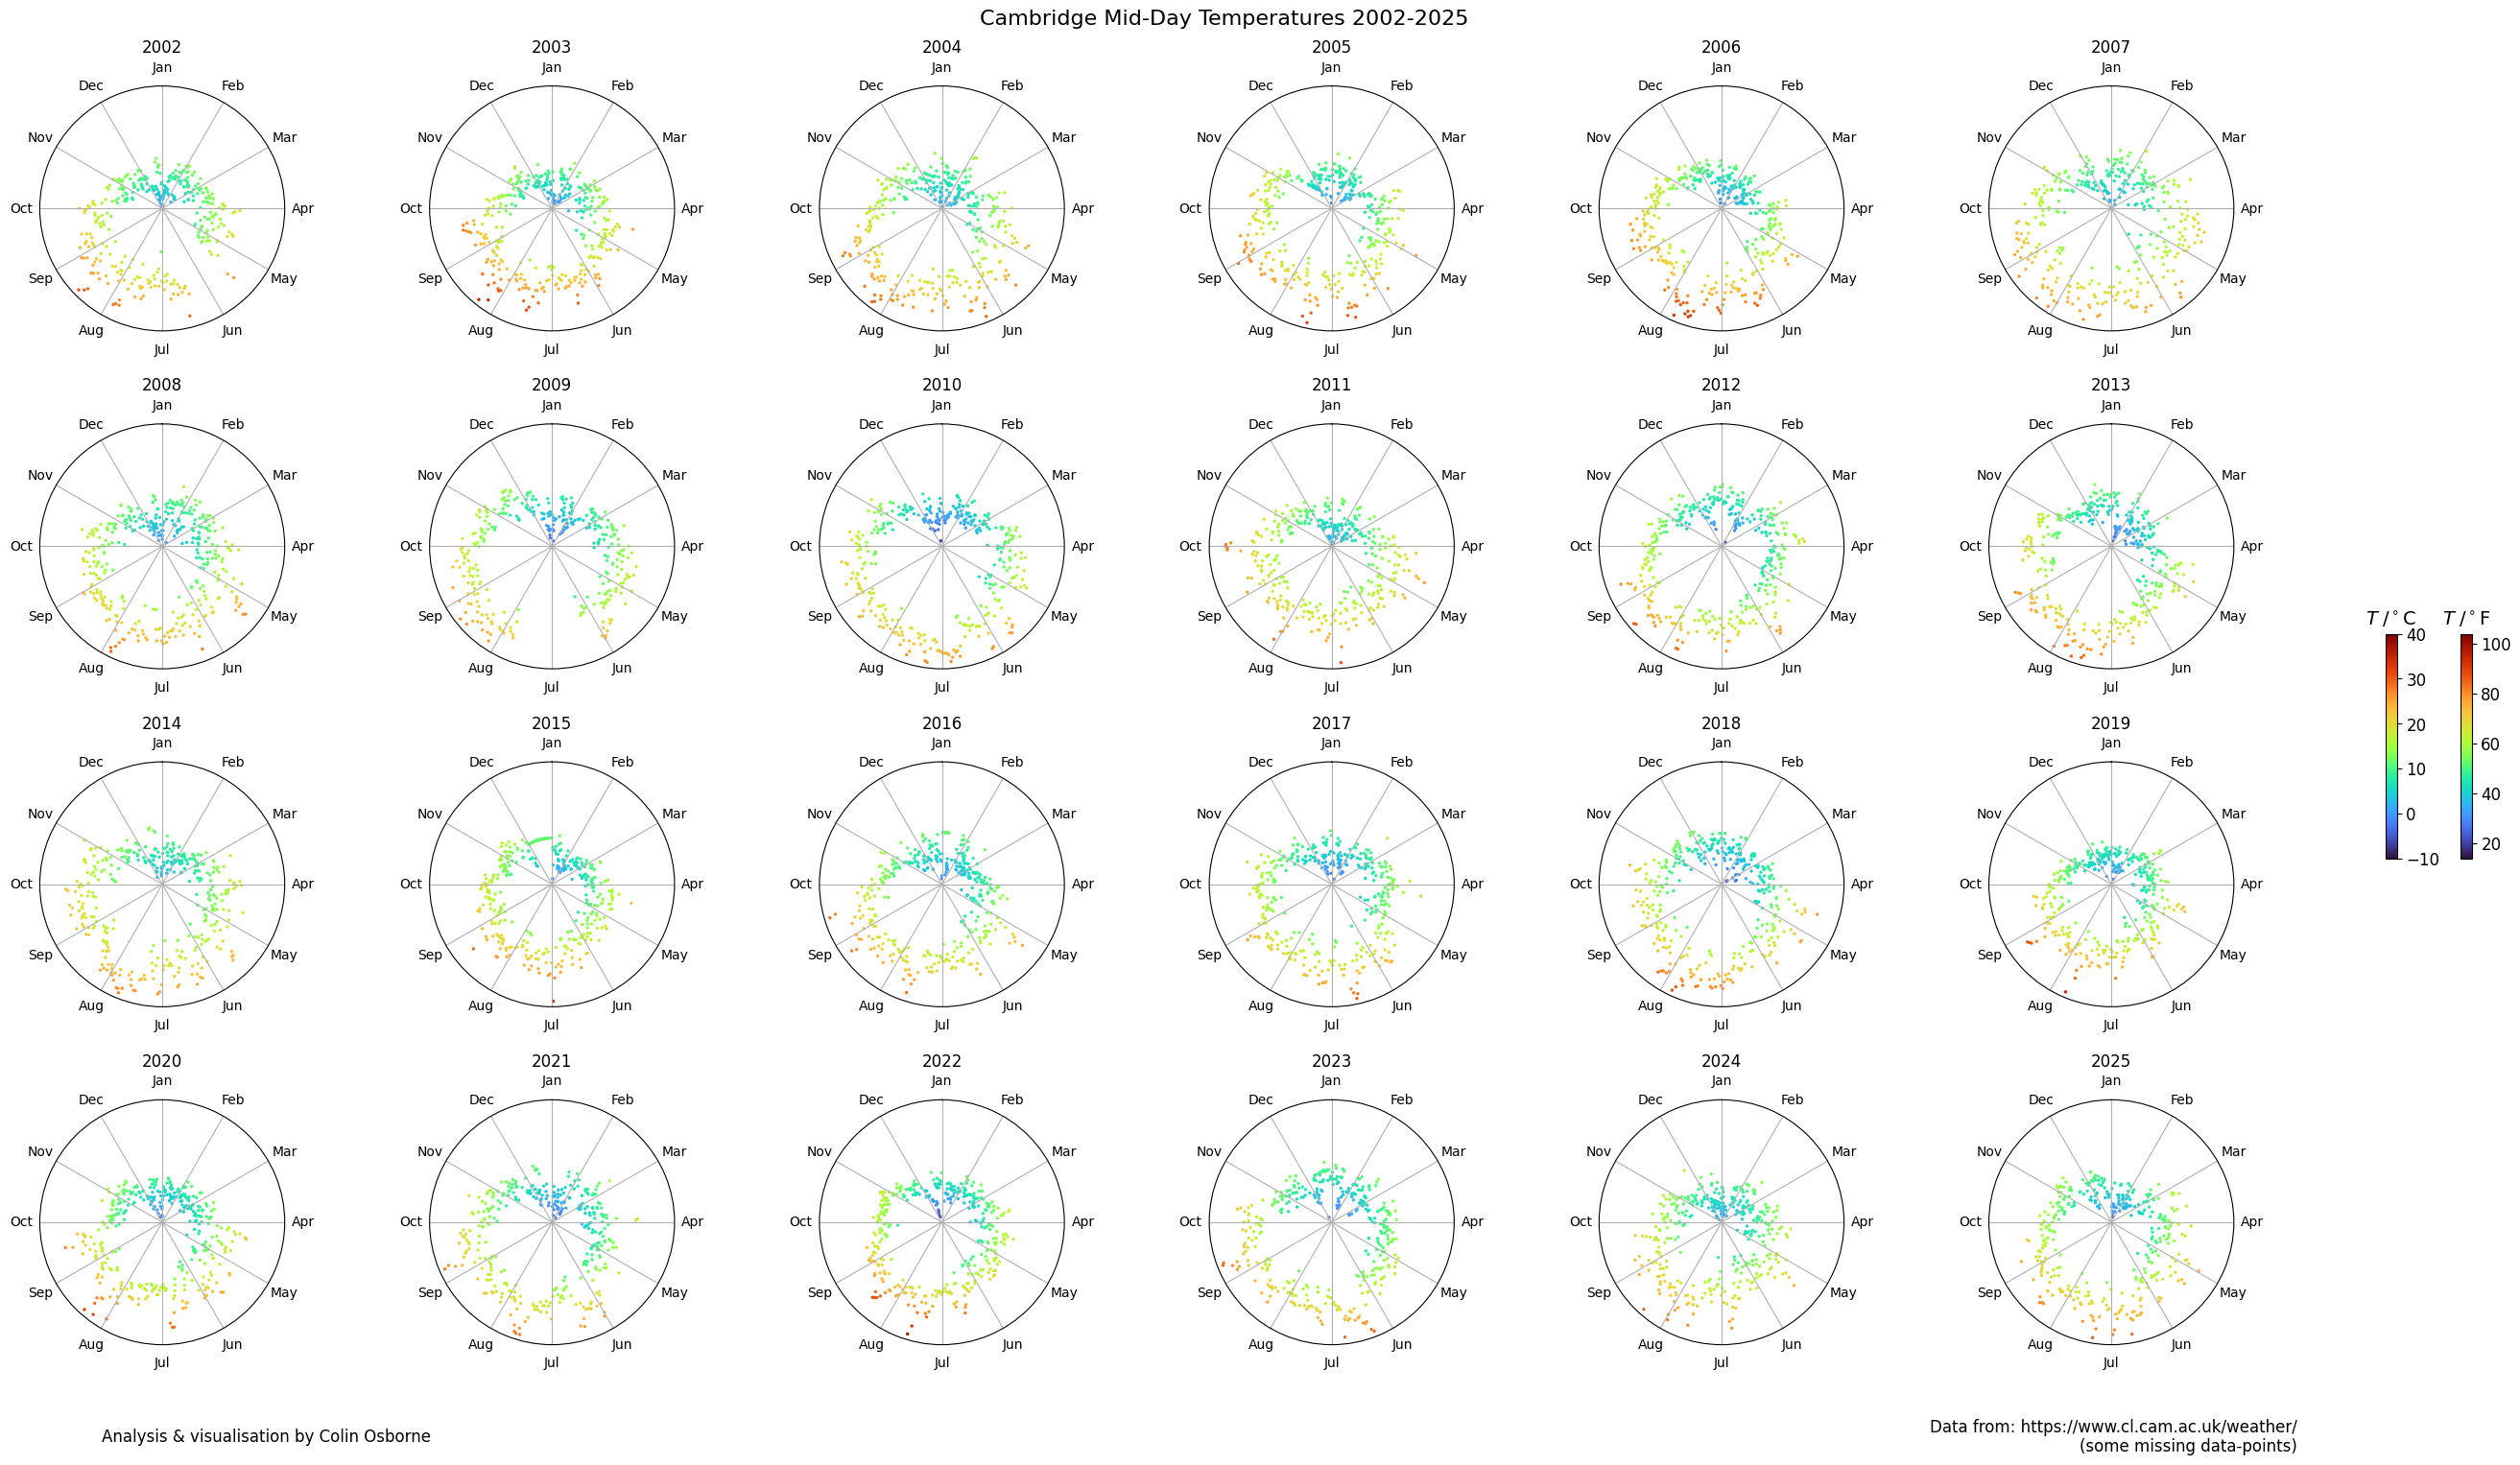

In [ ]:
def subplot_polar(df: pd.DataFrame, ax: plt.Axes, Tmin: float, Tmax: float, cbar: bool = True) -> None:
    """
    Plot a single year's data on a polar axis.
    Args:
        df: DataFrame for a single year, with 'angle' and 'Temp (deg C)'.
        ax: Matplotlib polar Axes to plot on.
        Tmin, Tmax: Min and max temperature for color normalization.
        cbar: If True, add colorbars (not used for subplots).
    """
    cmap = cm.turbo
    norm = Normalize(vmin=Tmin, vmax=Tmax)
    c = norm(df['Temp (deg C)'])
    ax.scatter(df['angle'], df['Temp (deg C)'], c=cmap(c), s=2)
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.set_xticks(np.arange(0, 2 * np.pi, np.pi / 6))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_yticks([])
    if cbar:
        # Only add colorbar if requested (not for subplots)
        fig = ax.get_figure()
        Tmin_F = Tmin * 9/5 + 32
        Tmax_F = Tmax * 9/5 + 32
        add_dual_colorbars(fig, cmap, Tmin, Tmax, Tmin_F, Tmax_F, left_c=0.72, left_f=0.80, bottom=0.10, width=0.07, height=0.8, fontsize=14)

def plot_polar_subplots(df_noon: pd.DataFrame, first_year: int, last_year: int, num_rows: int = 4, num_cols: int = None) -> None:
    """
    Plot a grid of polar subplots for each year in the data, with dual colorbars (°C and °F) stacked vertically.
    Args:
        df_noon: DataFrame with noon temperature data for all years.
        first_year: First year to plot.
        last_year: Last year to plot.
        num_rows: Number of subplot rows.
        num_cols: Number of subplot columns (optional).
    """
    year_list = list(range(first_year, last_year+1))
    num_years = len(year_list)
    if num_cols is None:
        num_cols = num_years//num_rows + (num_years % num_rows > 0)
    print('num years:', num_years, '; num_cols:', num_cols, '; num_rows:', num_rows)

    Tmin = 5 * np.floor(df_noon['Temp (deg C)'].min() / 5)
    Tmax = 5 * np.ceil(df_noon['Temp (deg C)'].max() / 5)
    Tmin_F = Tmin * 9/5 + 32
    Tmax_F = Tmax * 9/5 + 32

    fig, axs = plt.subplots(num_rows, num_cols,
                            subplot_kw=dict(projection='polar'),
                            figsize=(4*num_cols+2, 4*num_rows))
    for row in range(num_rows):
        for col in range(num_cols):
            n = row * num_cols + col
            if n < num_years:
                year = year_list[n]
                df_year = df_noon[df_noon['year']==year].copy()
                row_, col_ = divmod(n, num_cols)
                ax = axs[row_, col_]
                ax.set(title=year)
                subplot_polar(df_year, ax, Tmin, Tmax, cbar=False)
            else:
                ax = axs[row, col]
                ax.axis('off')

    plt.subplots_adjust(left=0, right=0.93, hspace=0.38, wspace=0.05, top=0.93)  # Reduced space above title
    # Stack colorbars vertically, make them taller
    cbar_ax_c = fig.add_axes([0.94, 0.15, 0.03, 0.7], frameon=False)
    cbar_ax_c.set_yticks([]), cbar_ax_c.set_xticks([])
    norm_c = Normalize(vmin=Tmin, vmax=Tmax)
    cmap = cm.turbo
    cbar_c = plt.colorbar(cm.ScalarMappable(norm=norm_c, cmap=cmap),
                         ax=cbar_ax_c, orientation='vertical')
    cbar_c.ax.set_title(r'$T\;/^\circ\mathrm{C}$', fontsize=14)
    cbar_c.ax.tick_params(labelsize=12)
    cbar_ax_f = fig.add_axes([0.97, 0.15, 0.03, 0.7], frameon=False)
    cbar_ax_f.set_yticks([]), cbar_ax_f.set_xticks([])
    norm_f = Normalize(vmin=Tmin_F, vmax=Tmax_F)
    cbar_f = plt.colorbar(cm.ScalarMappable(norm=norm_f, cmap=cmap),
                         ax=cbar_ax_f, orientation='vertical')
    cbar_f.ax.set_title(r'$T\;/^\circ\mathrm{F}$', fontsize=14)
    cbar_f.ax.tick_params(labelsize=12)

    plt.suptitle("Cambridge Mid-Day Temperatures {}-{}".format(first_year, last_year), fontsize=16)
    plt.figtext(0.05, 0.05, 'Analysis & visualisation by Colin Osborne', verticalalignment='center', horizontalalignment='left', fontsize=12)
    plt.figtext(0.93, 0.05, 'Data from: https://www.cl.cam.ac.uk/weather/\n(some missing data-points)', verticalalignment='center', horizontalalignment='right', fontsize=12)
    plt.show()
    fig.savefig('CambridgeMidDayTemps_{}_{}.png'.format(first_year, last_year))

# Call the function with current data
plot_polar_subplots(df_noon, df_noon['year'].min(), df_noon['year'].max(), num_rows=polar_plots_num_rows, num_cols=polar_plots_num_cols)
